In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
%load_ext rpy2.ipython

In [3]:
%R library(ggplot2)

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [4]:
#function to make df readable into R
def sametype(df):
    cols = df.columns
    for index, val in enumerate(cols):
        if df[val].dtype == 'O':
            df[val] = df[val].astype('str')
    return df

attendance analysis
---

In [5]:
#read DATA in

#first read in attendance data
attendance_df = pd.read_csv('../data/historical/HomeGames.csv')

#read in franchises for active or not
franchises_df = pd.read_csv('../data/historical/TeamsFranchises.csv')

#park info
parks_df = pd.read_csv('../data/historical/Parks.csv')

#team info
teams_df = pd.read_csv('../data/historical/Teams.csv')

#postseason stats
post_season_df = pd.read_csv('../data/historical/SeriesPost.csv')

#stadium history
current_stadium_df = pd.read_csv('../data/stadiums/current_stadiums.csv')
past_stadium_df = pd.read_csv('../data/stadiums/past_stadiums.csv')
#mycsv
stadium_historic = pd.read_csv('../data/stadiums/past_present_stadiums.csv', parse_dates=['year_opened'])

In [73]:
stadium_historic = pd.read_csv('../data/stadiums/past_present_stadiums.csv', parse_dates=['year_opened'])

In [7]:
active_franchises_df = franchises_df.loc[franchises_df.active == 'Y']

In [8]:
#goes from 2895 rows to 2656 when filtering for only active
#also filter for last 50 years, from year 1969 and number of rows is 1398
active_teams_df = teams_df.loc[(teams_df.franchID.isin(active_franchises_df.franchID)) & (teams_df.yearID > 1968)]

In [9]:
active_teams_df = active_teams_df[['yearID', 'lgID', 'teamID', 'franchID', 'Rank', 'W', 'name', 'park', 'attendance']]

In [10]:
active_teams_df.head()

,yearID,lgID,teamID,franchID,Rank,W,name,park,attendance
1517,1969,NL,ATL,ATL,1,93,Atlanta Braves,Atlanta-Fulton County Stadium,1458320.0
1518,1969,AL,BAL,BAL,1,109,Baltimore Orioles,Memorial Stadium,1062069.0
1519,1969,AL,BOS,BOS,3,87,Boston Red Sox,Fenway Park II,1833246.0
1520,1969,AL,CAL,ANA,3,71,California Angels,Anaheim Stadium,758388.0
1521,1969,AL,CHA,CHW,5,68,Chicago White Sox,Comiskey Park,589546.0


In [11]:
post_season_df[['yearID', 'round', 'teamIDwinner', 'teamIDloser']].head()

,yearID,round,teamIDwinner,teamIDloser
0,1884,WS,PRO,NY4
1,1885,WS,CHN,SL4
2,1886,WS,SL4,CHN
3,1887,WS,DTN,SL4
4,1888,WS,NY1,SL4


In [60]:
#need to see if made playoffs and worldseries that year
with_series = pd.merge(active_teams_df, post_season_df[['yearID', 'round', 'teamIDwinner']], how = 'left', right_on = ['yearID', 'teamIDwinner'], left_on = ['yearID', 'teamID'])
with_series = pd.merge(with_series, post_season_df[['yearID', 'round', 'teamIDloser']], how = 'left', right_on = ['yearID', 'teamIDloser'], left_on = ['yearID', 'teamID'])
with_series.rename(columns={'round_x':'round won', 'round_y':'round lost'}, inplace=True)
with_series = with_series.drop(['teamIDwinner', 'teamIDloser'], axis=1)

#with_series
with_series = sametype(with_series)
#with_series_over100 = with_series.loc[with_series.W > 100]
#with_series_under100 = with_series.loc[with_series.W < 100]
#with_series_under100.shape[0]
with_series.loc[(with_series['round won']=='nan') & (with_series['round lost']=='nan'), 'playoff_boolean'] = 'no'
with_series.loc[(with_series.playoff_boolean.isna()), 'playoff_boolean'] = 'yes'

add in column saying whether they made playoffs or not, due to join teams in the WS have 2 rows that season

In [63]:
with_series.head()

,yearID,lgID,teamID,franchID,Rank,W,name,park,attendance,prev_win,prev_attend,win_diff,attend_diff,attend_percent_change,round won,round lost,playoff_boolean
0,1969,NL,ATL,ATL,1,93,Atlanta Braves,Atlanta-Fulton County Stadium,1458320.0,82.0,2242695.0,11.0,-784375.0,-0.349747,nan,NLCS,yes
1,1969,AL,BAL,BAL,1,109,Baltimore Orioles,Memorial Stadium,1062069.0,90.0,2555781.0,19.0,-1493712.0,-0.584444,ALCS,WS,yes
2,1969,AL,BOS,BOS,3,87,Boston Red Sox,Fenway Park II,1833246.0,47.0,1564192.0,40.0,269054.0,0.172008,nan,nan,no
3,1969,AL,CAL,ANA,3,71,California Angels,Anaheim Stadium,758388.0,NaN,NaN,NaN,NaN,NaN,nan,nan,no
4,1969,AL,CHA,CHW,5,68,Chicago White Sox,Comiskey Park,589546.0,95.0,3181089.0,-27.0,-2591543.0,-0.814672,nan,nan,no


get delta between wins and attendance in previous season

In [15]:
active_teams_df['prev_win'] = active_teams_df.sort_values(['franchID', 'yearID']).shift(1)['W']

In [16]:
active_teams_df['prev_attend'] = active_teams_df.sort_values(['franchID', 'yearID']).shift(1)['attendance']

In [17]:
#win diff from previous year calculated as how many more or less win this year than the previous year
#and attendance diff from previous year
active_teams_df['win_diff'] = active_teams_df['W'] - active_teams_df['prev_win']
active_teams_df['attend_diff'] = active_teams_df['attendance'] - active_teams_df['prev_attend']

In [18]:
#calcualte percentage change for attendance becuase stadium sizes vary, probably not necessary for wins since all out of 162
active_teams_df['attend_percent_change'] = active_teams_df['attendance']/active_teams_df['prev_attend'] -1

In [19]:
active_teams_df.head()

,yearID,lgID,teamID,franchID,Rank,W,name,park,attendance,prev_win,prev_attend,win_diff,attend_diff,attend_percent_change
1517,1969,NL,ATL,ATL,1,93,Atlanta Braves,Atlanta-Fulton County Stadium,1458320.0,82.0,2242695.0,11.0,-784375.0,-0.349747
1518,1969,AL,BAL,BAL,1,109,Baltimore Orioles,Memorial Stadium,1062069.0,90.0,2555781.0,19.0,-1493712.0,-0.584444
1519,1969,AL,BOS,BOS,3,87,Boston Red Sox,Fenway Park II,1833246.0,47.0,1564192.0,40.0,269054.0,0.172008
1520,1969,AL,CAL,ANA,3,71,California Angels,Anaheim Stadium,758388.0,NaN,NaN,NaN,NaN,NaN
1521,1969,AL,CHA,CHW,5,68,Chicago White Sox,Comiskey Park,589546.0,95.0,3181089.0,-27.0,-2591543.0,-0.814672


In [20]:
with_series.head()

,yearID,lgID,teamID,franchID,Rank,W,name,park,attendance,round won,round lost,playoff_boolean
0,1969,NL,ATL,ATL,1,93,Atlanta Braves,Atlanta-Fulton County Stadium,1458320.0,NaN,NLCS,yes
1,1969,AL,BAL,BAL,1,109,Baltimore Orioles,Memorial Stadium,1062069.0,ALCS,WS,yes
2,1969,AL,BOS,BOS,3,87,Boston Red Sox,Fenway Park II,1833246.0,NaN,NaN,yes
3,1969,AL,CAL,ANA,3,71,California Angels,Anaheim Stadium,758388.0,NaN,NaN,yes
4,1969,AL,CHA,CHW,5,68,Chicago White Sox,Comiskey Park,589546.0,NaN,NaN,yes


In [21]:
#average the wins and attendance in a dataframe
mean_win_attend = active_teams_df.loc[active_teams_df.yearID > 1969][['franchID', 'W', 'attendance', 'attend_percent_change', 'win_diff']].groupby(['franchID']).mean().reset_index()

In [22]:
mean_win_attend.head()

,franchID,W,attendance,attend_percent_change,win_diff
0,ANA,80.653061,2.344005e+06,0.048176,0.183673
1,ARI,79.904762,2.428082e+06,-0.009079,0.095238
2,ATL,81.632653,1.982356e+06,0.064291,-0.061224
3,BAL,80.346939,2.150459e+06,0.024946,-1.265306
4,BOS,86.489796,2.363011e+06,0.020689,0.428571


In [23]:
playoff_appear = with_series.loc[with_series.playoff_boolean ==1][['franchID', 'playoff_boolean']].groupby(['franchID']).count().reset_index()

In [24]:
active_teams_df.head()

,yearID,lgID,teamID,franchID,Rank,W,name,park,attendance,prev_win,prev_attend,win_diff,attend_diff,attend_percent_change
1517,1969,NL,ATL,ATL,1,93,Atlanta Braves,Atlanta-Fulton County Stadium,1458320.0,82.0,2242695.0,11.0,-784375.0,-0.349747
1518,1969,AL,BAL,BAL,1,109,Baltimore Orioles,Memorial Stadium,1062069.0,90.0,2555781.0,19.0,-1493712.0,-0.584444
1519,1969,AL,BOS,BOS,3,87,Boston Red Sox,Fenway Park II,1833246.0,47.0,1564192.0,40.0,269054.0,0.172008
1520,1969,AL,CAL,ANA,3,71,California Angels,Anaheim Stadium,758388.0,NaN,NaN,NaN,NaN,NaN
1521,1969,AL,CHA,CHW,5,68,Chicago White Sox,Comiskey Park,589546.0,95.0,3181089.0,-27.0,-2591543.0,-0.814672


ONLY DOING TEAMS THAT ON AVERAGE WERE BETTER THAN LEAGUE AVERAGE
---

In [25]:
pert_teams = mean_win_attend.loc[mean_win_attend.W > mean_win_attend['W'].mean()]['franchID'].reset_index()
#take arizona out since formed 1998
pert_teams = pert_teams.loc[pert_teams.franchID != "ARI"]['franchID']
pert_teams

0     ANA
2     ATL
3     BAL
4     BOS
5     CIN
6     HOU
7     LAD
8     NYY
9     OAK
10    SFG
11    STL
Name: franchID, dtype: object

In [66]:
#lets look at 
pert_active_team_df = active_teams_df.loc[active_teams_df.franchID.isin(pert_teams)]

In [67]:
pert_series = with_series.loc[with_series.franchID.isin(pert_teams)]

In [68]:
pert_active_team_df.head()

,yearID,lgID,teamID,franchID,Rank,W,name,park,attendance,prev_win,prev_attend,win_diff,attend_diff,attend_percent_change
1517,1969,NL,ATL,ATL,1,93,Atlanta Braves,Atlanta-Fulton County Stadium,1458320.0,82.0,2242695.0,11.0,-784375.0,-0.349747
1518,1969,AL,BAL,BAL,1,109,Baltimore Orioles,Memorial Stadium,1062069.0,90.0,2555781.0,19.0,-1493712.0,-0.584444
1519,1969,AL,BOS,BOS,3,87,Boston Red Sox,Fenway Park II,1833246.0,47.0,1564192.0,40.0,269054.0,0.172008
1520,1969,AL,CAL,ANA,3,71,California Angels,Anaheim Stadium,758388.0,NaN,NaN,NaN,NaN,NaN
1523,1969,NL,CIN,CIN,3,89,Cincinnati Reds,Crosley Field,987991.0,62.0,1608817.0,27.0,-620826.0,-0.385890


In [69]:
pert_series.head()

,yearID,lgID,teamID,franchID,Rank,W,name,park,attendance,prev_win,prev_attend,win_diff,attend_diff,attend_percent_change,round won,round lost,playoff_boolean
0,1969,NL,ATL,ATL,1,93,Atlanta Braves,Atlanta-Fulton County Stadium,1458320.0,82.0,2242695.0,11.0,-784375.0,-0.349747,nan,NLCS,yes
1,1969,AL,BAL,BAL,1,109,Baltimore Orioles,Memorial Stadium,1062069.0,90.0,2555781.0,19.0,-1493712.0,-0.584444,ALCS,WS,yes
2,1969,AL,BOS,BOS,3,87,Boston Red Sox,Fenway Park II,1833246.0,47.0,1564192.0,40.0,269054.0,0.172008,nan,nan,no
3,1969,AL,CAL,ANA,3,71,California Angels,Anaheim Stadium,758388.0,NaN,NaN,NaN,NaN,NaN,nan,nan,no
6,1969,NL,CIN,CIN,3,89,Cincinnati Reds,Crosley Field,987991.0,62.0,1608817.0,27.0,-620826.0,-0.385890,nan,nan,no


In [70]:
t2 = pd.merge(pert_active_team_df, pert_series[['yearID', 'lgID', 'teamID', 'franchID', 'playoff_boolean']], how = 'left')
#with_series = pd.merge(active_teams_df, post_season_df[['yearID', 'round', 'teamIDwinner']], how = 'left', right_on = ['yearID', 'teamIDwinner'], left_on = ['yearID', 'teamID'])



In [71]:
t2.head()

,yearID,lgID,teamID,franchID,Rank,W,name,park,attendance,prev_win,prev_attend,win_diff,attend_diff,attend_percent_change,playoff_boolean
0,1969,NL,ATL,ATL,1,93,Atlanta Braves,Atlanta-Fulton County Stadium,1458320.0,82.0,2242695.0,11.0,-784375.0,-0.349747,yes
1,1969,AL,BAL,BAL,1,109,Baltimore Orioles,Memorial Stadium,1062069.0,90.0,2555781.0,19.0,-1493712.0,-0.584444,yes
2,1969,AL,BOS,BOS,3,87,Boston Red Sox,Fenway Park II,1833246.0,47.0,1564192.0,40.0,269054.0,0.172008,no
3,1969,AL,CAL,ANA,3,71,California Angels,Anaheim Stadium,758388.0,NaN,NaN,NaN,NaN,NaN,no
4,1969,NL,CIN,CIN,3,89,Cincinnati Reds,Crosley Field,987991.0,62.0,1608817.0,27.0,-620826.0,-0.385890,no


In [74]:
#make year stand alone in stadium historic
stadium_historic['year_opened'] = stadium_historic.year_opened.dt.year

In [75]:
stadium_historic.head(2)

,franchID,Stadium_name,year_opened,capacity
0,ANA,Angel Stadium,1966.0,45517.0
1,ATL,Atlanta-Fulton County Stadium,1966.0,52007.0


In [76]:
pert_df = pd.merge(t2,stadium_historic, how ='left', right_on = ['franchID', 'Stadium_name'],left_on = ['franchID', 'park'])
pert_df = pert_df.drop(['Stadium_name'], axis=1)
#start from 1970 
#pert_df = pert_df.loc[pert_df.yearID > 1969]
pert_df = pert_df.drop_duplicates()

In [77]:
#add in column for previous year playoff
pert_df['prev_playoff'] = pert_df.sort_values(['franchID', 'yearID']).shift(1)['playoff_boolean']

In [78]:
pert_df.head()

,yearID,lgID,teamID,franchID,Rank,W,name,park,attendance,prev_win,prev_attend,win_diff,attend_diff,attend_percent_change,playoff_boolean,year_opened,capacity,prev_playoff
0,1969,NL,ATL,ATL,1,93,Atlanta Braves,Atlanta-Fulton County Stadium,1458320.0,82.0,2242695.0,11.0,-784375.0,-0.349747,yes,1966.0,52007.0,no
1,1969,AL,BAL,BAL,1,109,Baltimore Orioles,Memorial Stadium,1062069.0,90.0,2555781.0,19.0,-1493712.0,-0.584444,yes,1954.0,47855.0,yes
2,1969,AL,BOS,BOS,3,87,Boston Red Sox,Fenway Park II,1833246.0,47.0,1564192.0,40.0,269054.0,0.172008,no,1912.0,37755.0,no
3,1969,AL,CAL,ANA,3,71,California Angels,Anaheim Stadium,758388.0,NaN,NaN,NaN,NaN,NaN,no,1966.0,45517.0,NaN
4,1969,NL,CIN,CIN,3,89,Cincinnati Reds,Crosley Field,987991.0,62.0,1608817.0,27.0,-620826.0,-0.385890,no,1912.0,29488.0,yes


In [79]:
#% of stadium filled
1458320.0/82
pert_df['percent_filled'] = (pert_df.attendance/82)/pert_df.capacity

In [80]:
#add in column for new stadium
pert_df.loc[pert_df.yearID == pert_df.year_opened, 'new_stadium'] = 'yes'
pert_df.loc[(pert_df.new_stadium.isna()), 'new_stadium'] = 'no'

In [107]:
pert_df = sametype(pert_df)

In [81]:
pert_df.sort_values('percent_filled', ascending = False)

,yearID,lgID,teamID,franchID,Rank,W,name,park,attendance,prev_win,prev_attend,win_diff,attend_diff,attend_percent_change,playoff_boolean,year_opened,capacity,prev_playoff,percent_filled,new_stadium
483,2009,AL,BOS,BOS,2,95,Boston Red Sox,Fenway Park II,3062699.0,95.0,3048250.0,0.0,14449.0,0.004740,yes,1912.0,37755.0,yes,0.989273,no
509,2011,AL,BOS,BOS,3,90,Boston Red Sox,Fenway Park II,3054001.0,89.0,3046443.0,1.0,7558.0,0.002481,no,1912.0,37755.0,no,0.986463,no
516,2011,NL,SFN,SFG,2,86,San Francisco Giants,AT&T Park,3387303.0,92.0,3037443.0,-6.0,349860.0,0.115182,no,2000.0,41915.0,yes,0.985532,no
472,2008,AL,BOS,BOS,2,95,Boston Red Sox,Fenway Park II,3048250.0,96.0,2970755.0,-1.0,77495.0,0.026086,yes,1912.0,37755.0,yes,0.984605,no
331,1997,AL,BAL,BAL,1,98,Baltimore Orioles,Oriole Park at Camden Yards,3711132.0,88.0,3646950.0,10.0,64182.0,0.017599,yes,1992.0,45971.0,yes,0.984484,no
496,2010,AL,BOS,BOS,3,89,Boston Red Sox,Fenway Park II,3046443.0,95.0,3062699.0,-6.0,-16256.0,-0.005308,no,1912.0,37755.0,yes,0.984022,no
522,2012,AL,BOS,BOS,5,69,Boston Red Sox,Fenway Park II,3043003.0,90.0,3054001.0,-21.0,-10998.0,-0.003601,no,1912.0,37755.0,no,0.982911,no
529,2012,NL,SFN,SFG,1,94,San Francisco Giants,AT&T Park,3377371.0,86.0,3387303.0,8.0,-9932.0,-0.002932,yes,2000.0,41915.0,no,0.982642,no
571,2015,NL,SFN,SFG,2,84,San Francisco Giants,AT&T Park,3375882.0,88.0,3368697.0,-4.0,7185.0,0.002133,no,2000.0,41915.0,yes,0.982209,no
557,2014,NL,SFN,SFG,2,88,San Francisco Giants,AT&T Park,3368697.0,76.0,3326796.0,12.0,41901.0,0.012595,yes,2000.0,41915.0,no,0.980119,no


In [104]:
win_attend_playoffs = pd.merge(pert_df[['franchID', 'W', 'percent_filled',]].groupby('franchID').mean().reset_index(), pert_df[['franchID', 'playoff_boolean']].loc[pert_df.playoff_boolean == 'yes'].groupby('franchID').count().reset_index(), on = 'franchID')

In [103]:
pert_df[['franchID', 'playoff_boolean']].loc[pert_df.playoff_boolean == 'yes'].groupby('franchID').count().reset_index()

,franchID,playoff_boolean
0,ANA,10
1,ATL,20
2,BAL,12
3,BOS,17
4,CIN,11
5,HOU,12
6,LAD,19
7,NYY,25
8,OAK,19
9,SFG,11


In [105]:
win_attend_playoffs

,franchID,W,percent_filled,playoff_boolean
0,ANA,80.46,0.619520,10
1,ATL,81.86,0.480706,20
2,BAL,80.92,0.557264,12
3,BOS,86.50,0.759846,17
4,CIN,81.66,0.511128,11
5,HOU,80.40,0.526673,12
6,LAD,85.84,0.669418,19
7,NYY,89.20,0.585870,25
8,OAK,82.68,0.395734,19
9,SFG,80.92,0.515795,11


In [108]:
%R -i pert_df

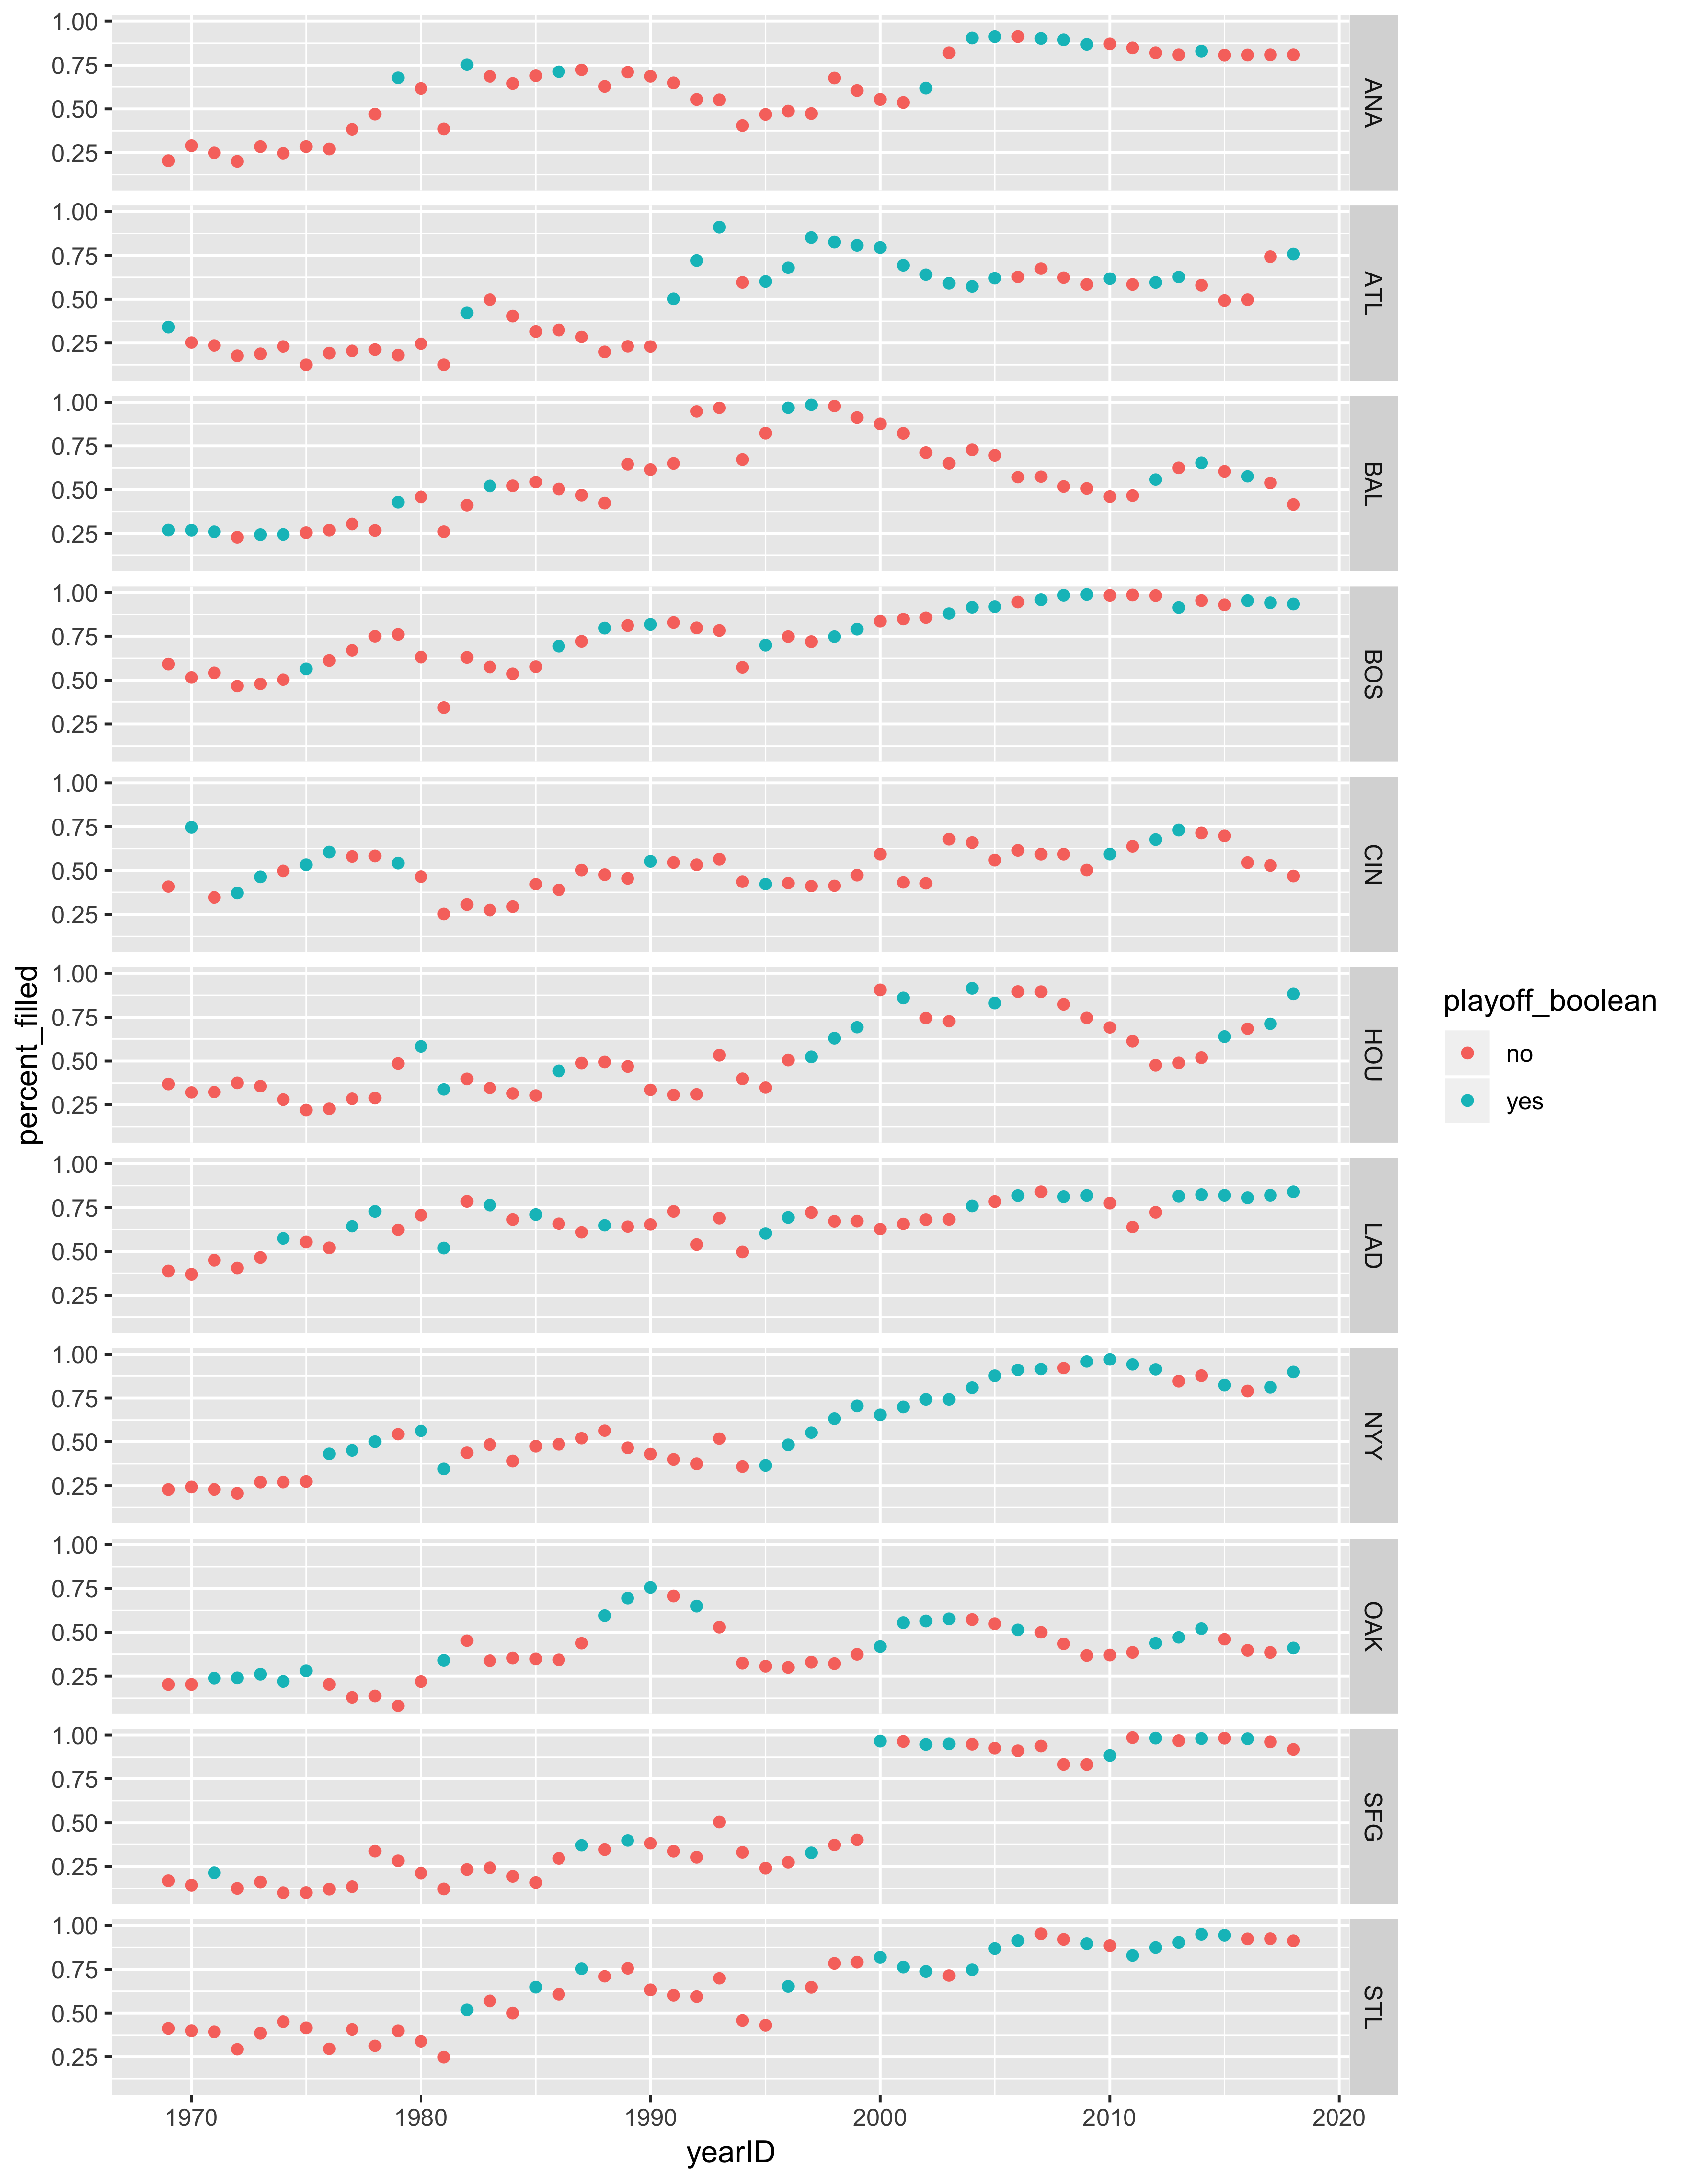

In [117]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot(pert_df, aes(x=yearID,y=percent_filled, group = 1)) + 
    geom_point(aes(colour = playoff_boolean), size = 1.5) + 
    facet_grid(rows = vars(franchID))
#ggsave('../images/attend_percentage.pdf')

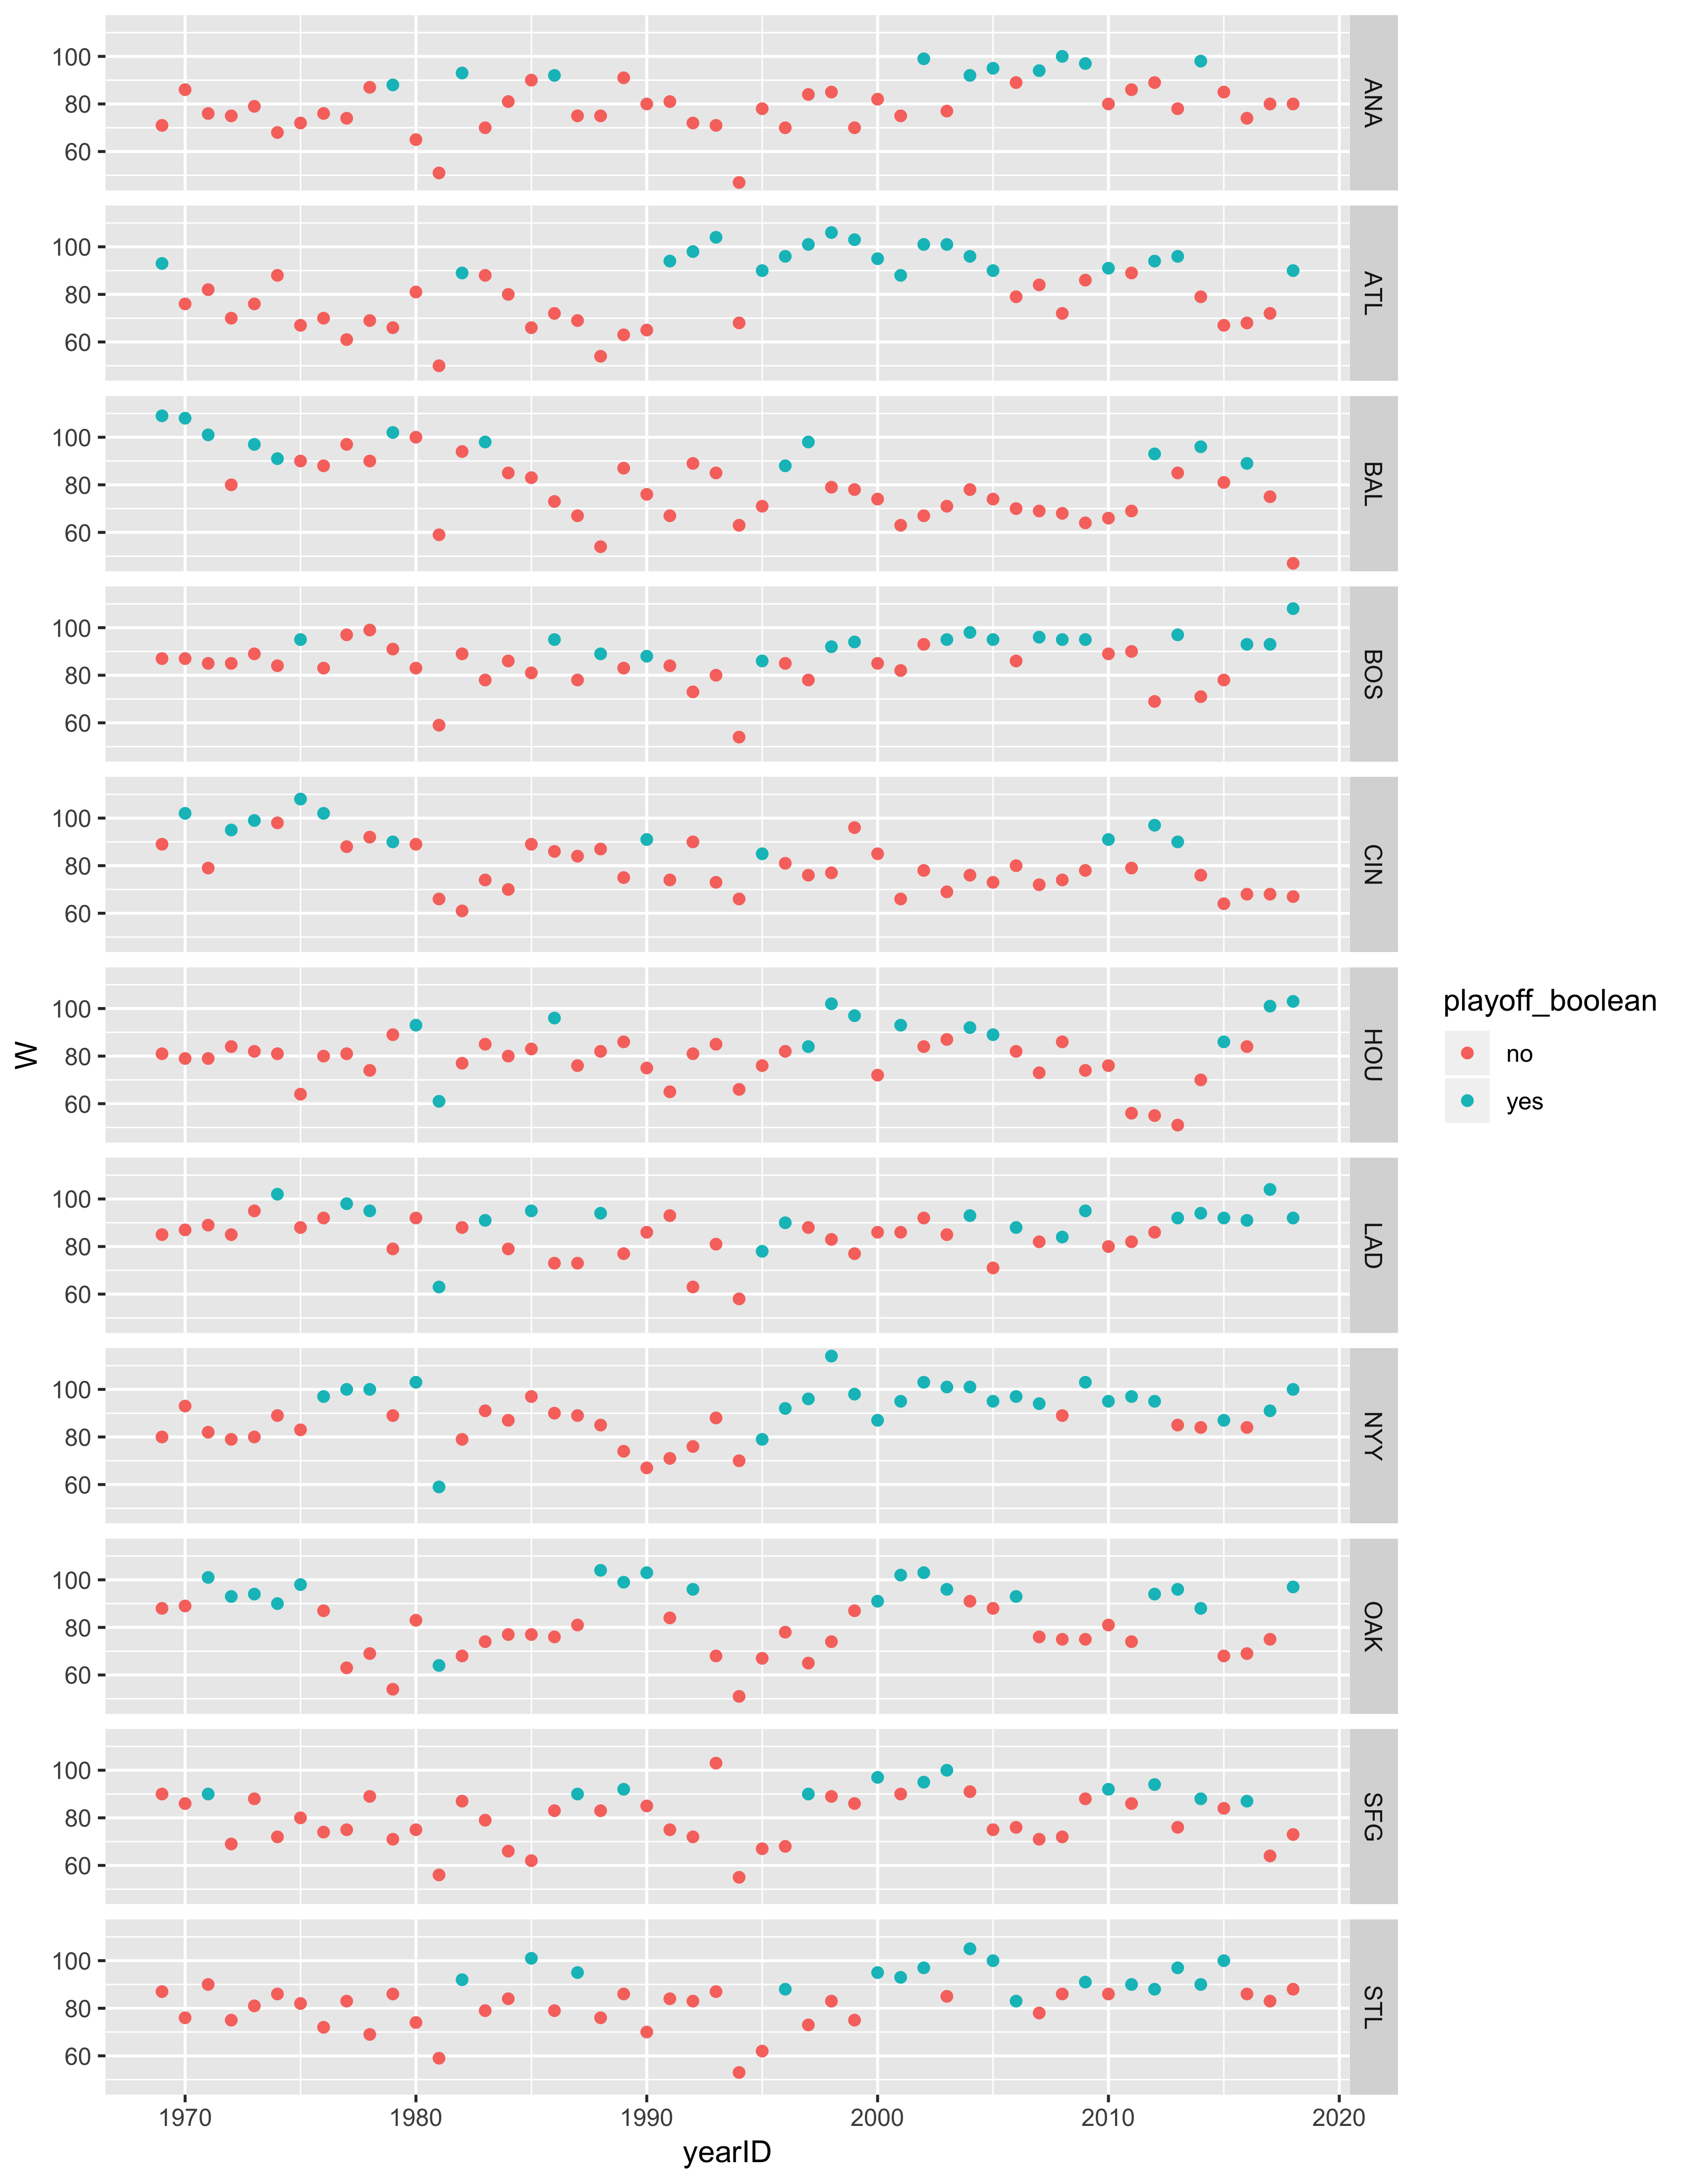

In [118]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot(pert_df, aes(x=yearID,y=W, group = 1)) + 
    geom_point(aes(colour = playoff_boolean), size = 1.5) + 
    facet_grid(rows = vars(franchID))
#ggsave('../images/win_overtime.pdf')

APPENDIX - graveyard code
---

In [82]:
%R -i active_teams_df

In [83]:
%R -i with_series

In [84]:
%R -i mean_win_attend

In [85]:
#%R -i mean_win_attend_2

In [86]:
%R -i playoff_appear

graph1: lets see what team has been to playoffs the most since 1969

graph2: order by mean attend percent change 

graph3: order by win mean


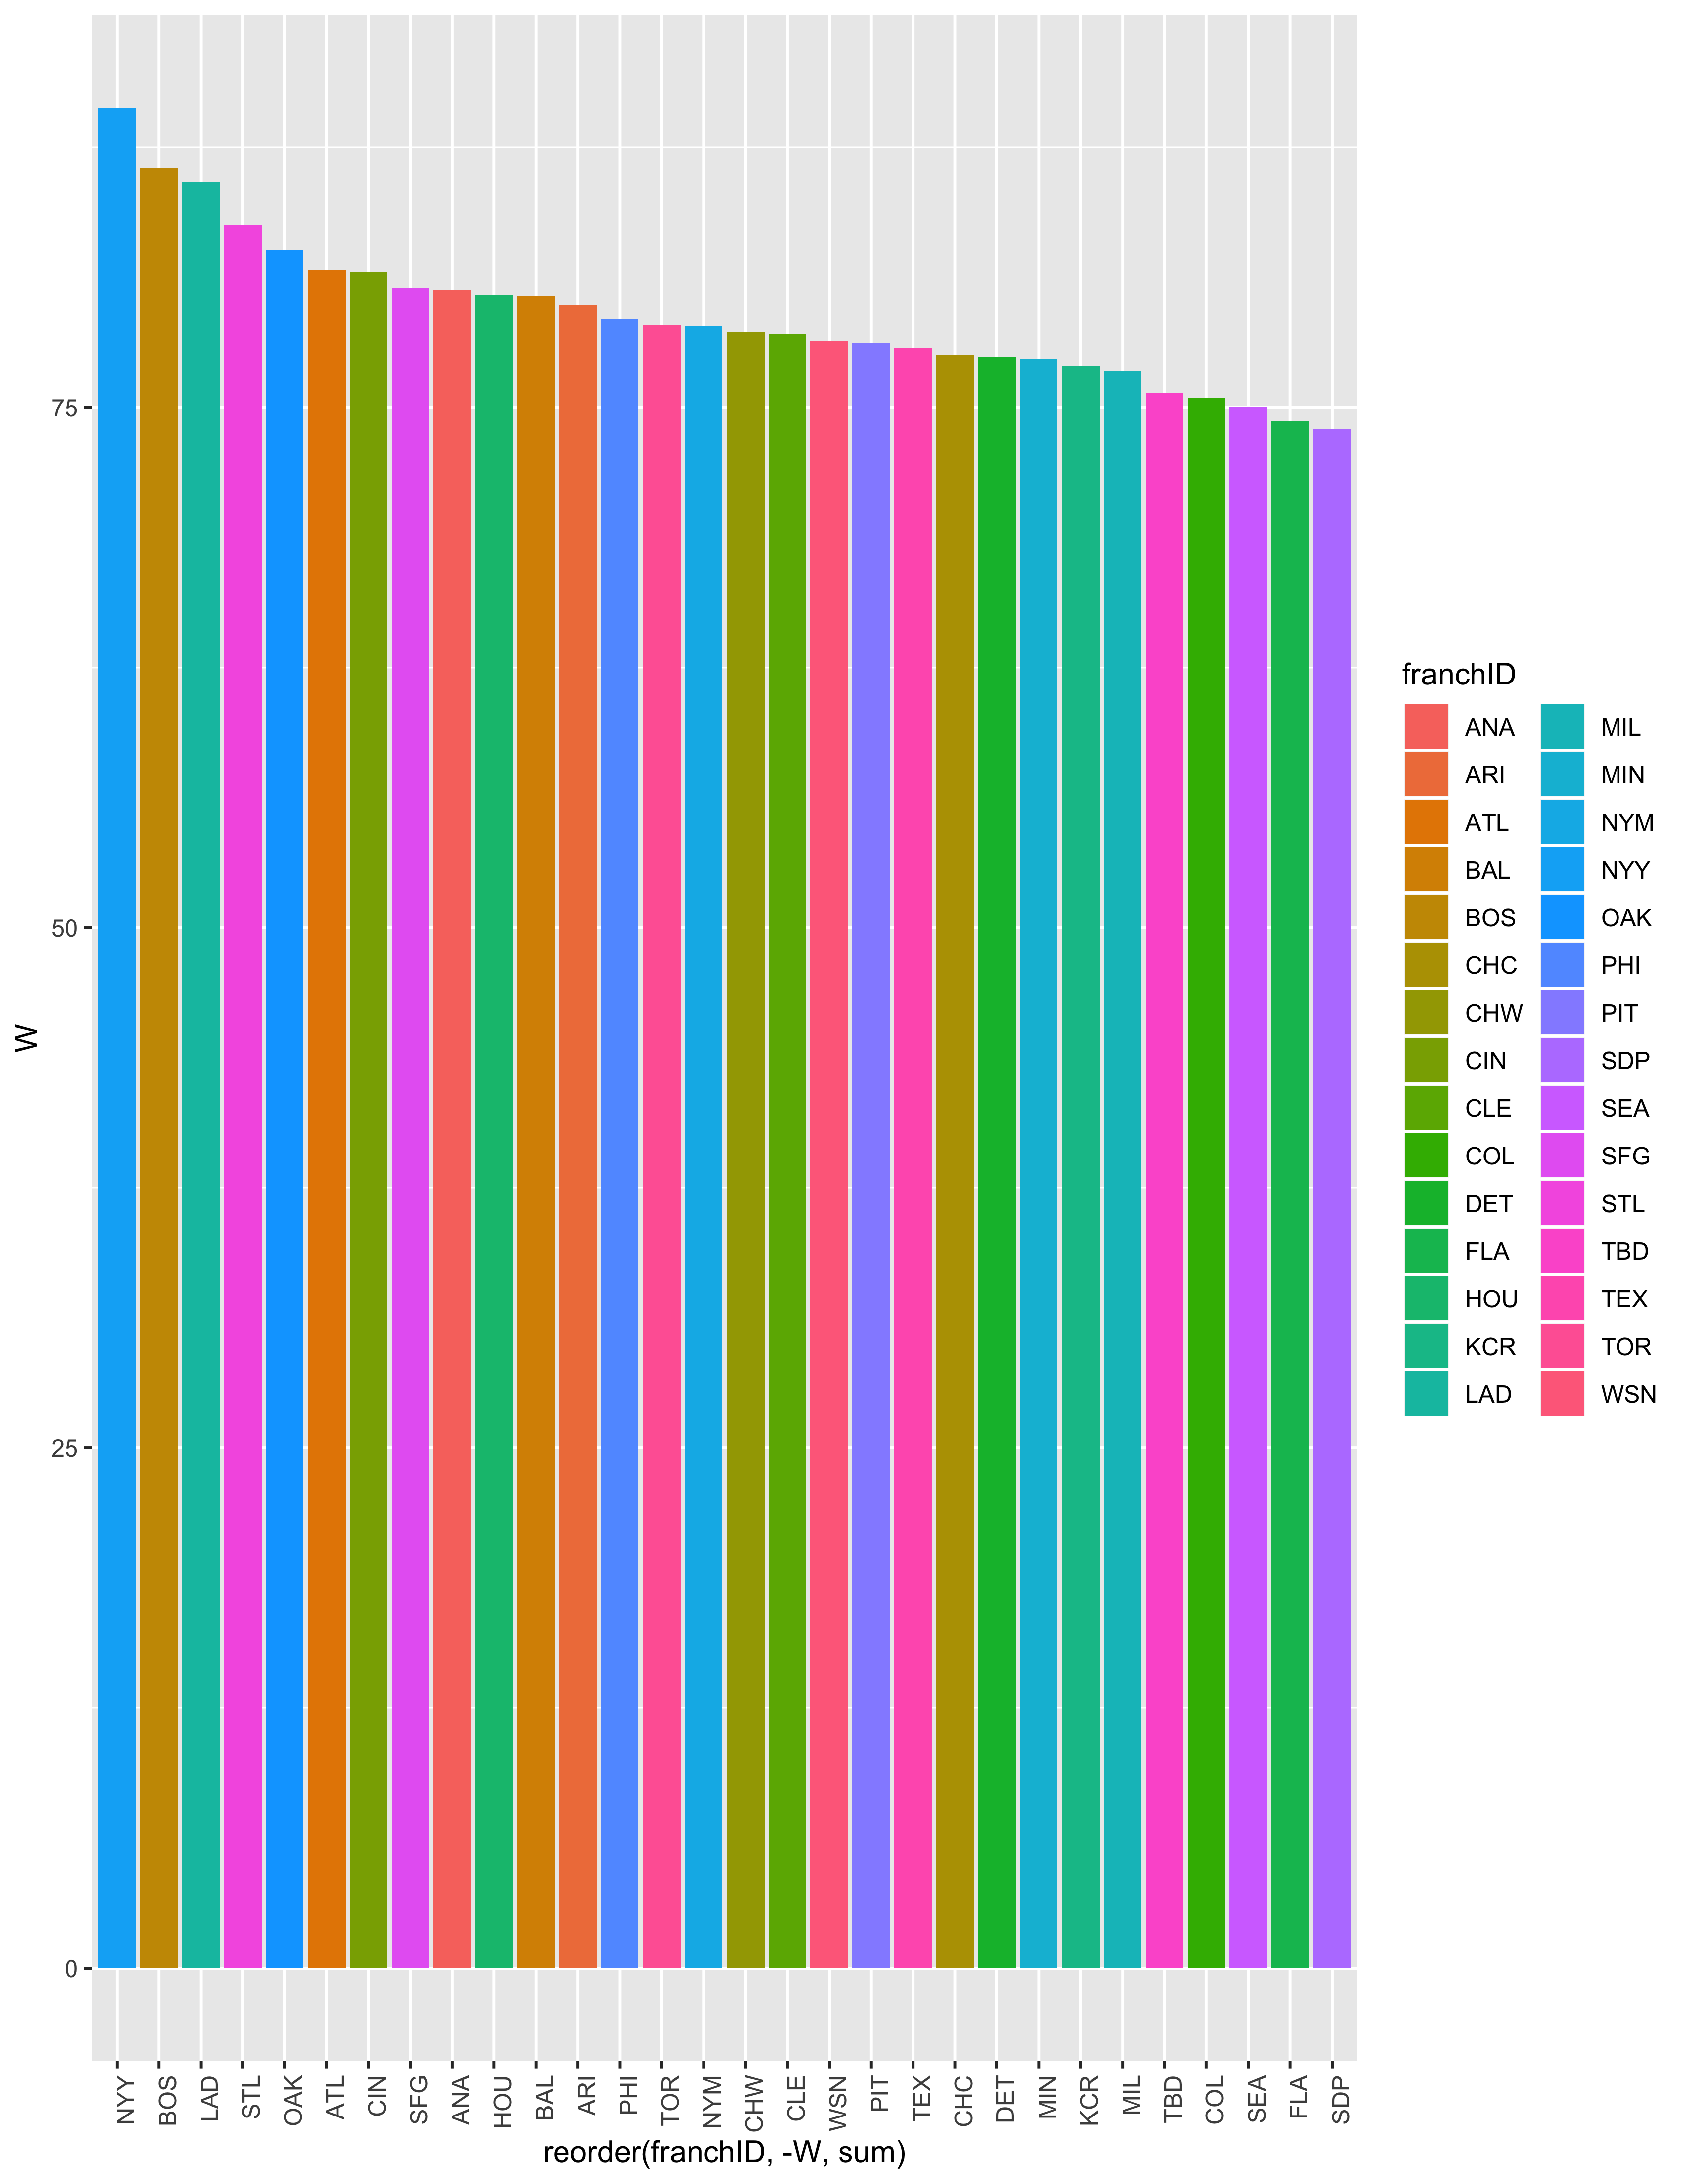

In [89]:
%%R -w 8.5 -h 11 --units in -r 400

#mean_win_attend$franchID <- factor(mean_win_attend$franchID, levels=unique(as.character(mean_win_attend$franchID )) )

ggplot(data = mean_win_attend, aes(x=reorder(franchID,-W,sum), y = W, fill = franchID)) + 
    geom_bar(stat = 'identity') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) #+
    #xlim(rev(levels(mean_win_attend$franchID)))
#ggsave('../images/avg_wins.pdf')

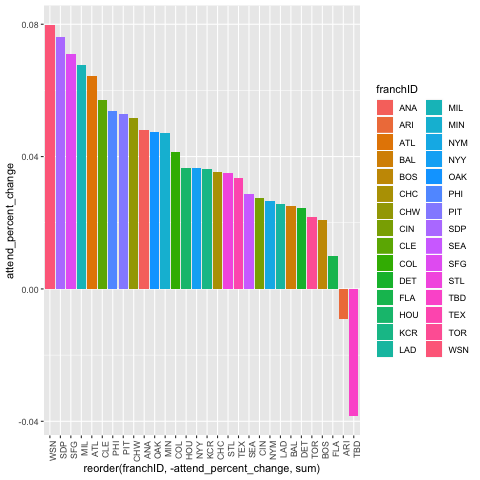

In [90]:
%%R

ggplot(data = mean_win_attend, aes(x=reorder(franchID,-attend_percent_change,sum), y = attend_percent_change, fill = franchID)) + 
    geom_bar(stat = 'identity') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

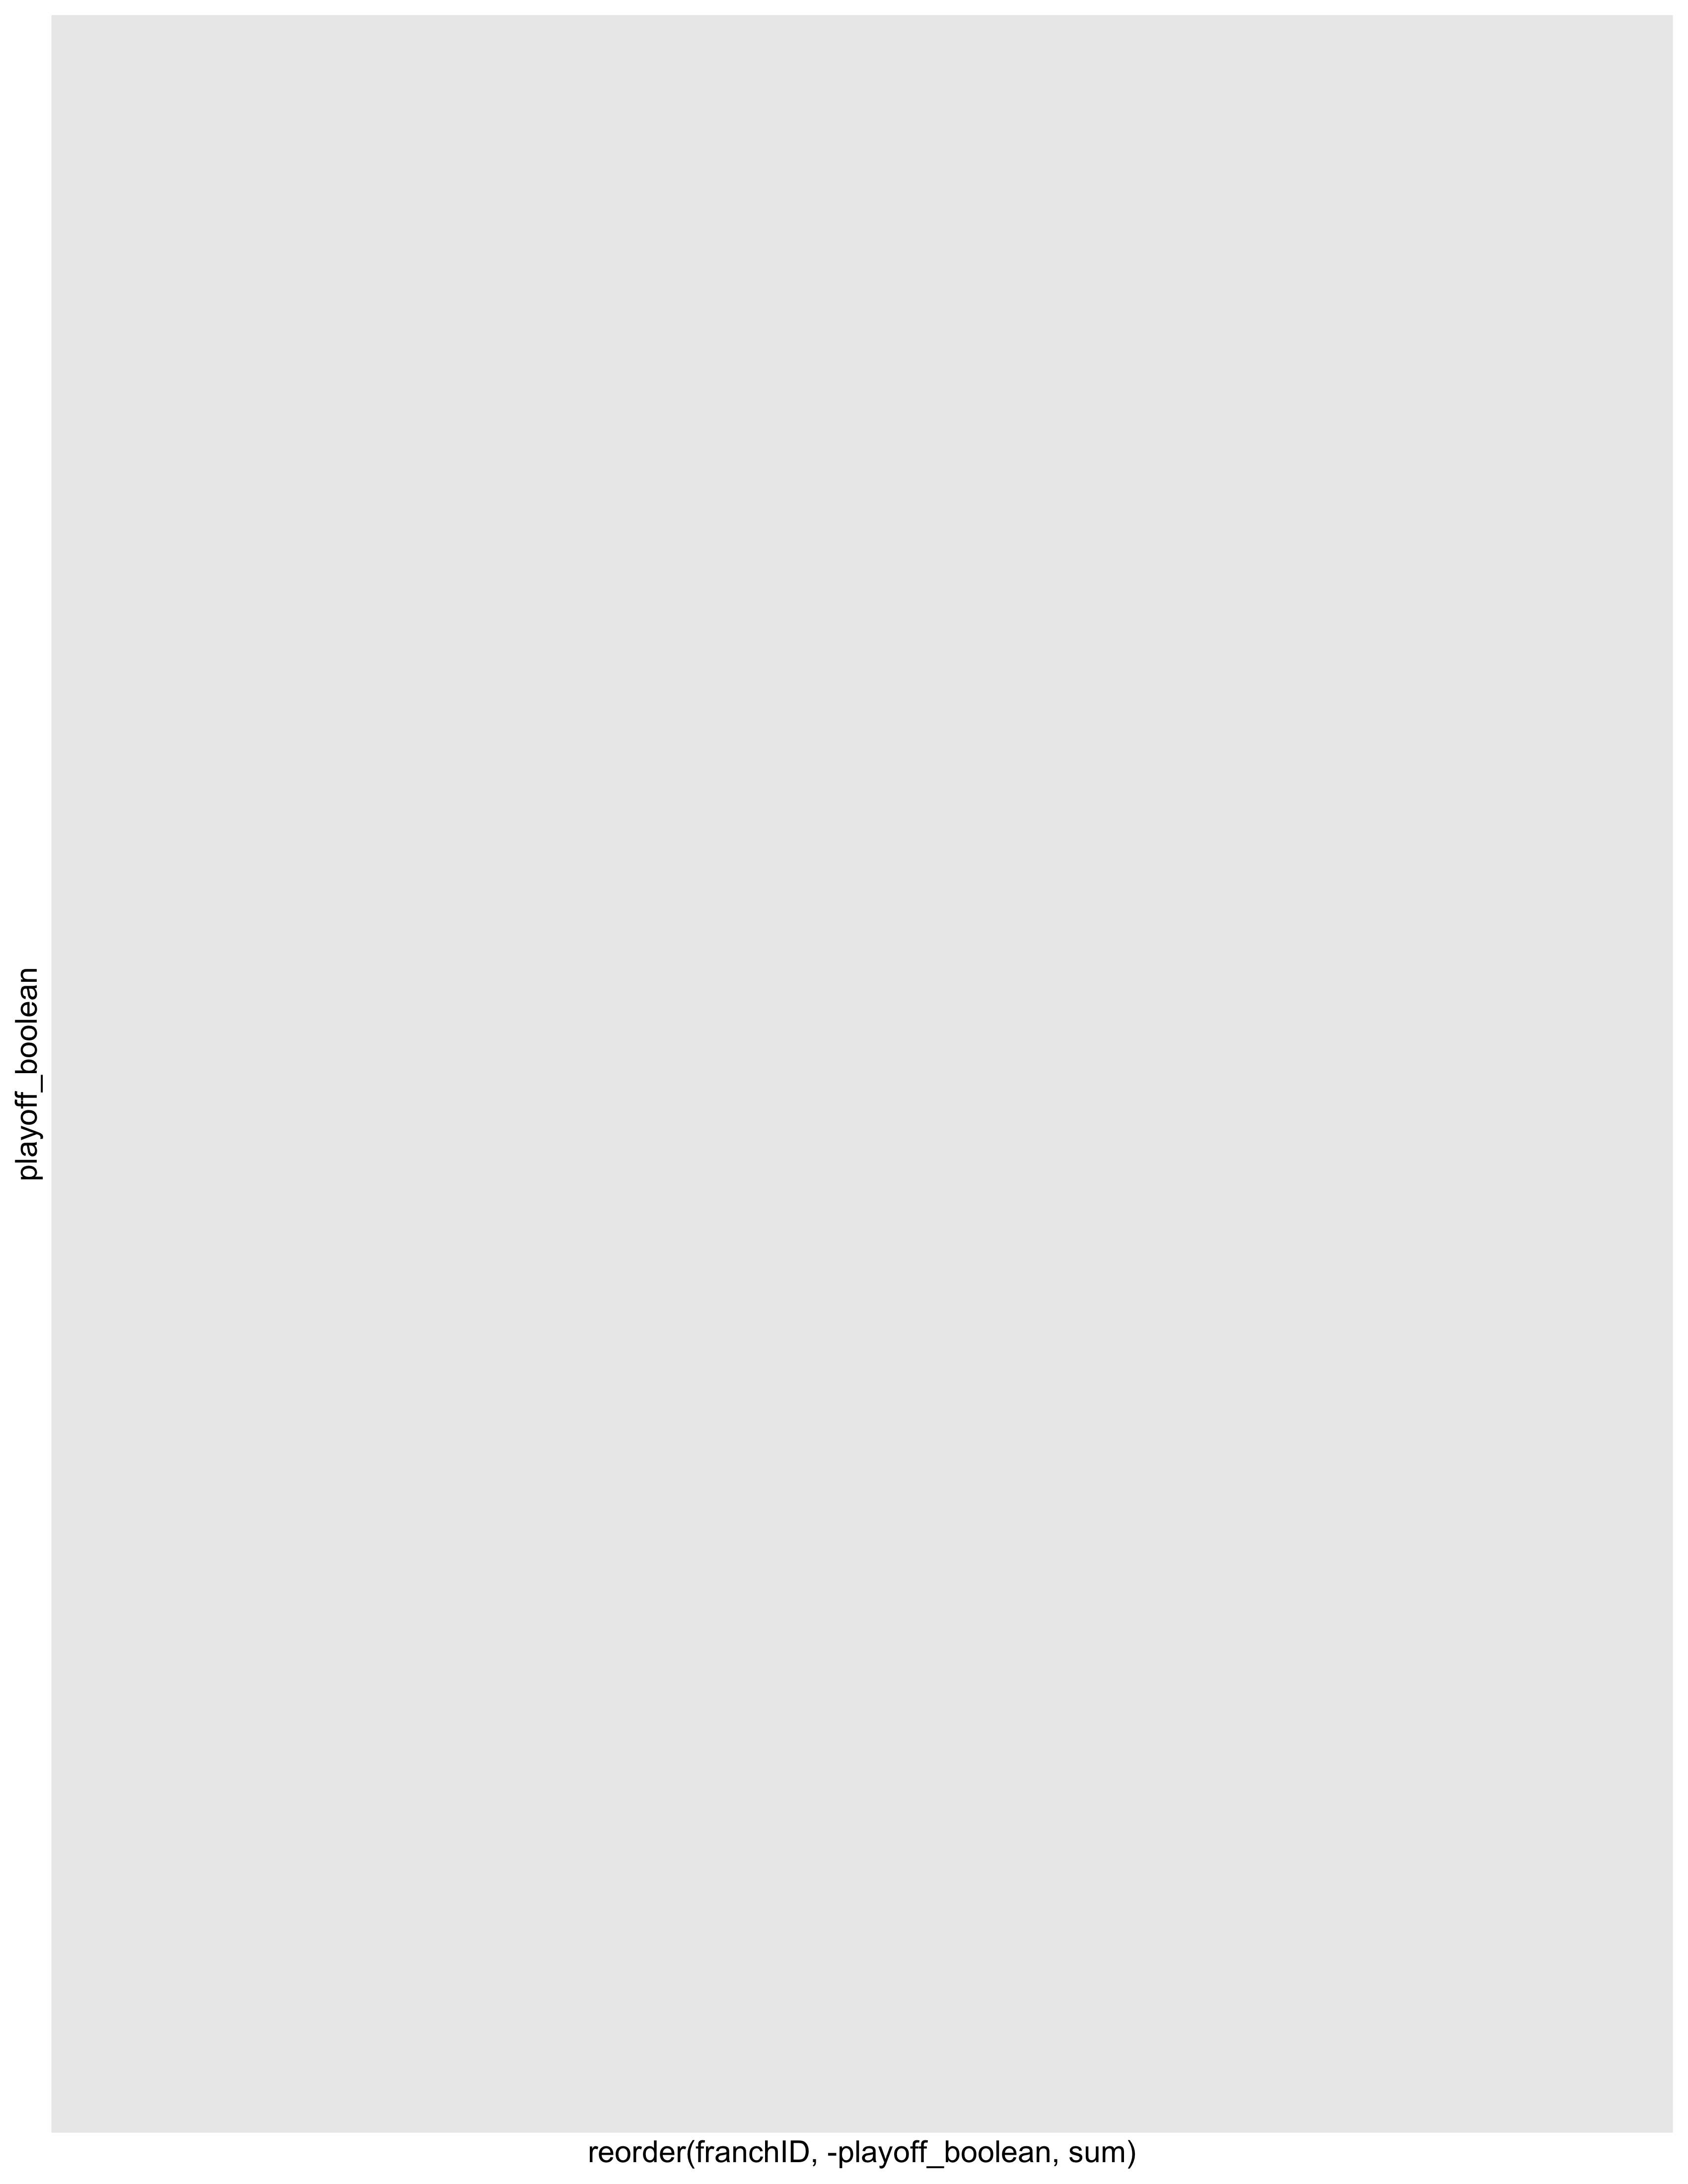

In [91]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot(data = playoff_appear, aes(x=reorder(franchID,-playoff_boolean,sum), y = playoff_boolean, fill = franchID)) + 
    geom_bar(stat = 'identity') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

#ggsave('../images/playoff_appearances.pdf')

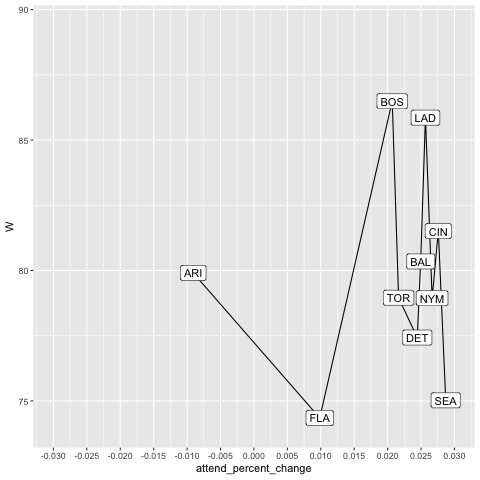

In [92]:
%%R 
#-w 8.5 -h 11 --units in -r 400

ggplot(data = mean_win_attend) + 
geom_line(aes(x = attend_percent_change, y=W)) + 
geom_label(aes(x = attend_percent_change, y=W, label = franchID)) +
scale_x_continuous(limits = c(-.03,0.03), breaks = seq(-0.03,0.03,.005))

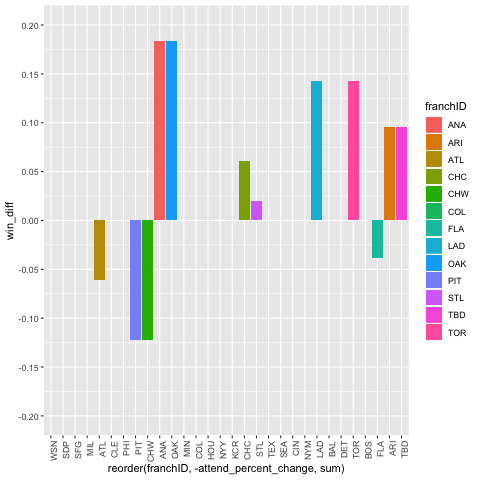

In [93]:
%%R

ggplot(data = mean_win_attend, aes(x=reorder(franchID,-attend_percent_change,sum), y = win_diff, fill = franchID)) + 
    geom_bar(stat = 'identity') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) + scale_y_continuous(limits = c(-.2,0.2), breaks = seq(-0.2,0.2,.05))



stadium stuff
---